In [1]:
from lcdb.db import LCDB
from lcdb.analysis.util import LearningCurveExtractor, merge_curves, LearningCurve

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]

openmlid = 6
workflow = workflows[0]

# retrieve learning curve objects
lcdb = LCDB()
df = lcdb.query(
    openmlids=[openmlid],
    workflows=[workflow],
    return_generator=False,
    processors={
        "learning_curve": LearningCurveExtractor(
            metrics=["error_rate"],
            folds=["train", "val"]
        )
    },
    show_progress=True
)

# group by configurations
config_cols = [c for c in df.columns if c.startswith("p:")]
df = df.groupby(config_cols).agg({"learning_curve": merge_curves})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]


In [3]:
max_schedule = df["learning_curve"].iloc[0].anchors_size

In [4]:
df["learning_curve"].apply(lambda x: x.pad_anchors_size(max_schedule, inplace=True))

p:metric       p:n_neighbors  p:pp@cat_encoder  p:pp@decomposition  p:pp@featuregen  p:pp@featureselector  p:pp@scaler  p:weights  p:p  p:pp@kernel_pca_kernel  p:pp@kernel_pca_n_components  p:pp@poly_degree  p:pp@selectp_percentile  p:pp@std_with_std
cosine         1              onehot            fastica             none             selectp               std          distance   1    linear                  0.25                          2                 82                       False                <lcdb.analysis.util.LearningCurve object at 0x...
                              ordinal           fastica             none             selectp               std          uniform    1    linear                  0.25                          2                 93                       False                <lcdb.analysis.util.LearningCurve object at 0x...
                                                                    poly             selectp               std          distance   1    linea

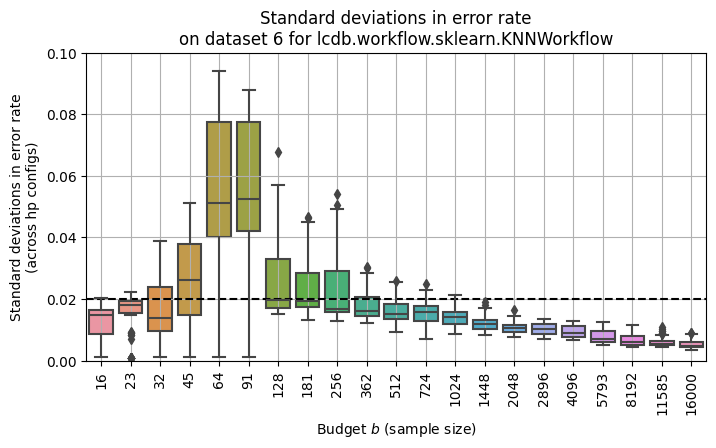

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
stds = np.array([np.nanstd(lc.values[0, 1], axis=(0, 1, 2)) for lc in df["learning_curve"]])
ax.axhline(0.02, color="black", linestyle="--")

sb.boxplot(stds, ax=ax)
ax.set_ylim([0, 0.1])
ax.set_xticklabels(max_schedule, rotation=90)
ax.set_title(f"Standard deviations in error rate\non dataset {openmlid} for {workflow}")
ax.set_xlabel("Budget $b$ (sample size)")
ax.set_ylabel("Standard deviations in error rate\n(across hp configs)")
ax.grid()
plt.show()